# Concept Bottleneck model concept recall accuracy

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.path.pardir, 'src')))

from policy import ConceptNet, LiteModel, FastPredictor
from jem import data_utils

model_name = 'net'
session_name =  'falcon'
board_size = 5
nr_of_concepts = data_utils.get_number_of_concepts()
load_dataset = False

benchmark_model_path = "../models/cbm/net_1000.keras"

agents_to_sample = [100, 200, 300, 500, 700, 1000]
cases_to_sample = 100

full_model_path = f"../models/cbm/"

def load_model(full_name, epoch):
    model_path = full_name + model_name + "_" + str(epoch) + ".keras"
    model = ConceptNet(board_size, load_path=model_path)
    return model

agents = [load_model(full_model_path, epoch) for epoch in agents_to_sample]

In [2]:
if load_dataset:
    states, concepts = data_utils.load_cbm_dataset()
else:
    states, concepts = data_utils.generate_binary_concept_encodings(agents, cases_to_sample, board_size)

print(f'Generated dataset containing {states.shape[0]} states and {concepts.shape[0]} concepts')

Generating binary encodings for board size 5


Generating concept datasets for concept: null: 175it [00:11, 15.11it/s]                        
Generating concept datasets for concept: play_center_in_opening: 128it [00:16,  7.84it/s]                        
Generating concept datasets for concept: two_eyes: 100%|██████████| 100/100 [26:10<00:00, 15.70s/it]
Generating concept datasets for concept: one_eye: 142it [00:33,  4.21it/s]                        
Generating concept datasets for concept: capture_a_stone: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]
Generating concept datasets for concept: capture_group_of_stones: 103it [01:31,  1.12it/s]                        
Generating concept datasets for concept: area_advantage: 151it [00:09, 16.38it/s]                        

Generated dataset containing 700 states and 700 concepts


In [32]:
# Save the dataset to pickle
data_utils.save_cbm_dataset(states, concepts)

Saving dataset for CBM


In [33]:
model = ConceptNet(board_size, nr_of_concepts, load_path=benchmark_model_path)
concepts_pred = model.predict_concepts(states)

In [39]:
concepts_gt_dict = data_utils.concept_functions_to_dict()
concepts_pred_dict = data_utils.concept_functions_to_dict()

# Plot the accuracy of each individual concept in the bottleneck layer
for i, concept in tqdm(enumerate(concepts), total=len(concepts), desc='Calculating concept accuracy'):
    # Find the index with the highest value in the prediction
    pred = concepts_pred[i]
    
    # Find all the indices where the concept is 1
    concept_indices = np.where(concept == 1)[0]
    for idx in concept_indices:
        concept_name = data_utils.concept_idx_to_name(idx)
        concepts_gt_dict[concept_name] += 1
    
    # Find the index of the 2 largest values in the prediction
    pred_indices = np.argpartition(pred, -3)[-3:]
    for idx in pred_indices:
        if idx in concept_indices:
            concept_name = data_utils.concept_idx_to_name(idx)
            concepts_pred_dict[concept_name] += 1
            concept_indices = concept_indices[concept_indices != idx]
        
        if len(concept_indices) == 0:
            break

Calculating concept accuracy: 100%|██████████| 1000/1000 [00:02<00:00, 429.53it/s]


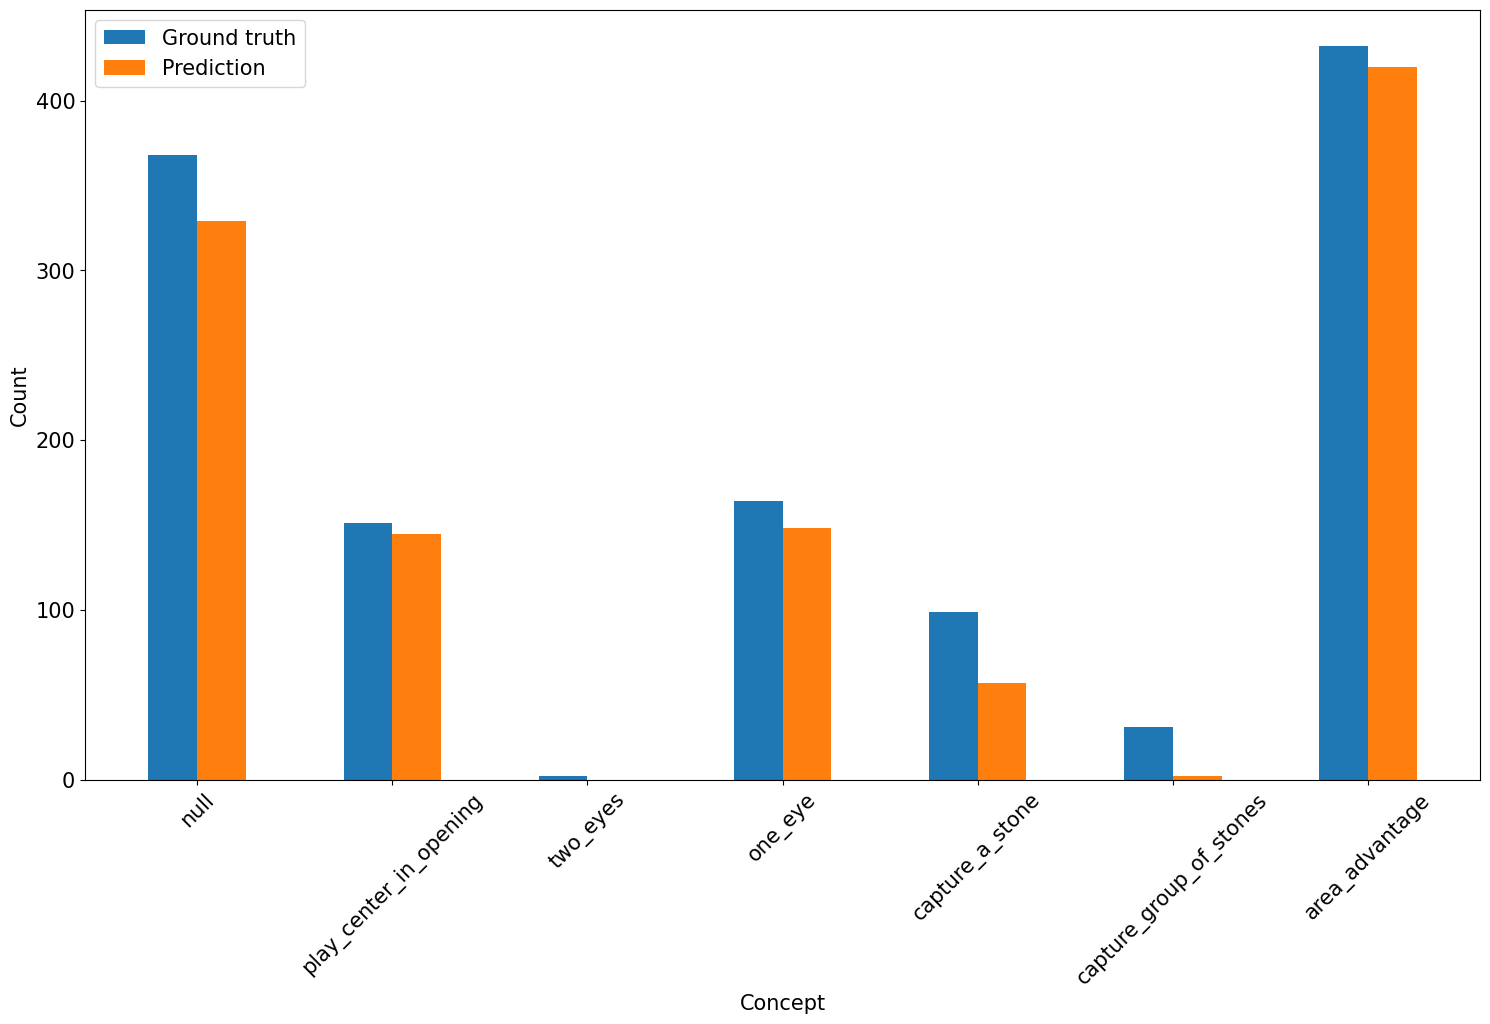

In [40]:
# Plot the concepts_gt_dict and concepts_pred_dict
fig, ax = plt.subplots()
index = np.arange(len(concepts_gt_dict.keys()))
bar_width = 0.25

# Set the window size
fig.set_size_inches(18, 10)

rects1 = ax.bar(index, concepts_gt_dict.values(), bar_width, label='Ground truth')
rects2 = ax.bar(index + bar_width, concepts_pred_dict.values(), bar_width, label='Prediction')

ax.set_xlabel('Concept', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
#ax.set_title('Concept bottleneck model predictions', fontsize=20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(concepts_gt_dict.keys())

# Add this line to increase the font size of the x-ticks to 15
ax.tick_params(axis='x', labelsize=15, rotation=45)

# Add this line to increase the font size of the y-ticks to 15
ax.tick_params(axis='y', labelsize=15)
ax.legend(fontsize=15)

plt.show()

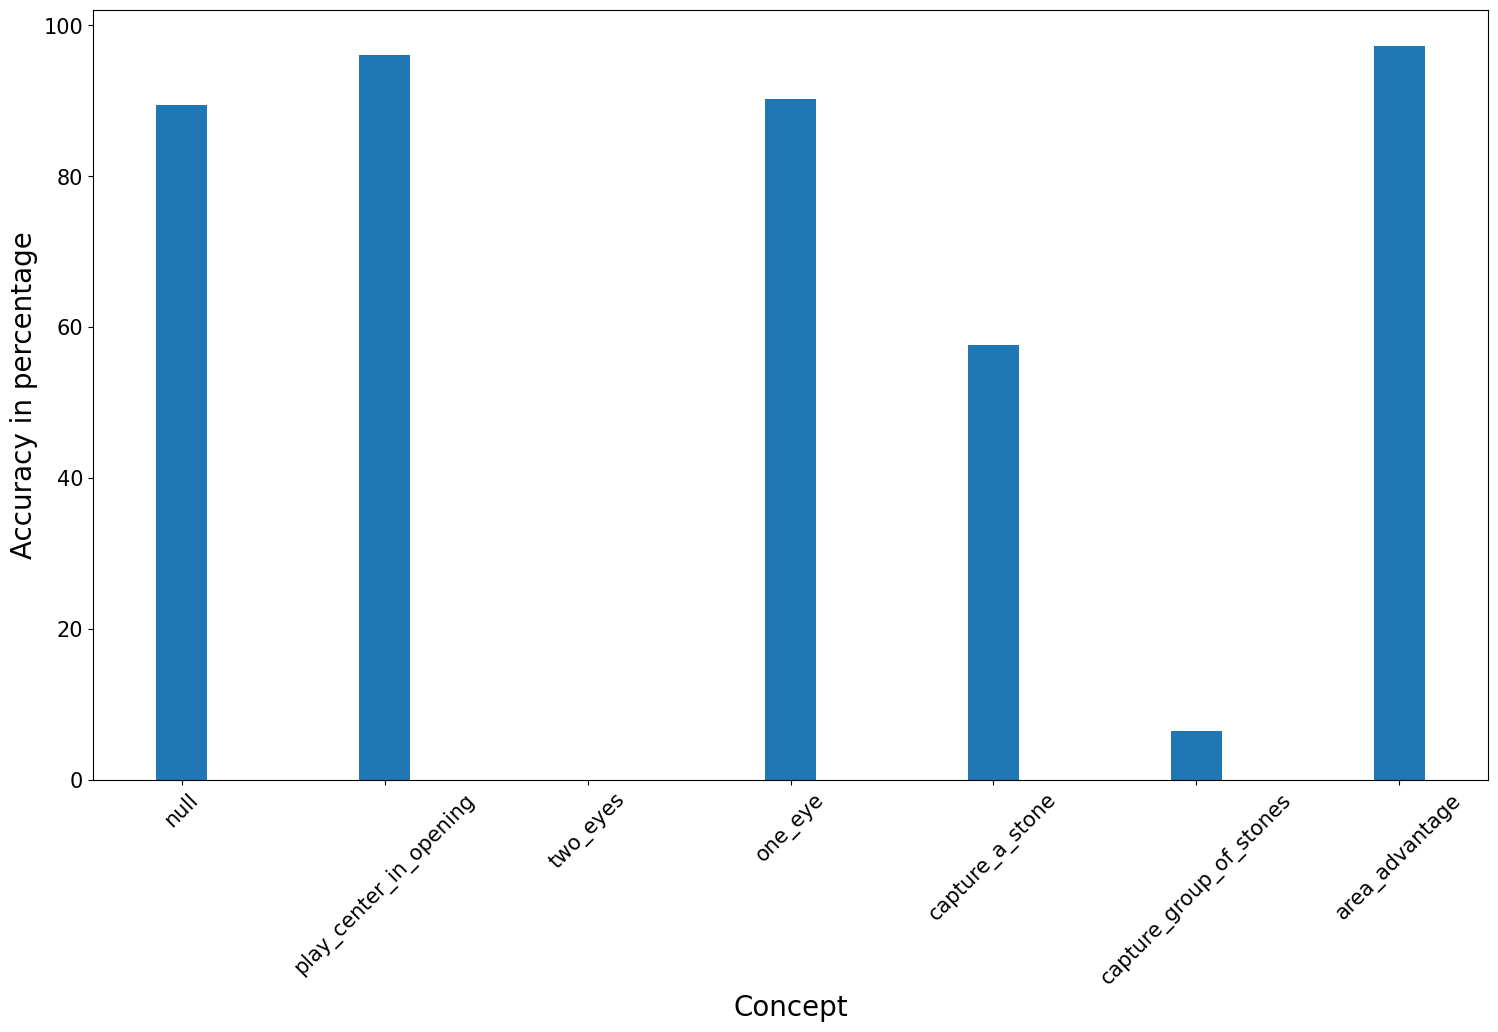

In [41]:
# Plot of the accuracy of the concept bottleneck output in percentage of the ground truth
fig, ax = plt.subplots()
index = np.arange(len(concepts_gt_dict.keys()))
bar_width = 0.25

# Set the window size
fig.set_size_inches(18, 10)

for key in concepts_gt_dict.keys():
    if concepts_gt_dict[key] == 0:
        concepts_gt_dict[key] = 0
    else:
        concepts_gt_dict[key] = concepts_pred_dict[key] / concepts_gt_dict[key] * 100

rects1 = ax.bar(index, concepts_gt_dict.values(), bar_width)

ax.set_xlabel('Concept', fontsize=20)
ax.set_ylabel('Accuracy in percentage', fontsize=20)
#ax.set_title('Concept bottleneck model accuracy', fontsize=20)
ax.set_xticks(index)
ax.set_xticklabels(concepts_gt_dict.keys())

# Add this line to increase the font size of the x-ticks to 15
ax.tick_params(axis='x', labelsize=15, rotation=45)

# Add this line to increase the font size of the y-ticks to 15
ax.tick_params(axis='y', labelsize=15)

plt.show()

## Experimental testing of the concept prediction leadning to correct move from distribution

In [8]:
mcts_simulations = 100
cases_to_sample = 1000

lite_agents = []
for agent in agents:
    lite_agent = FastPredictor(LiteModel.from_keras_model(agent.model))
    lite_agents.append(lite_agent)
    
states, concepts, distributions = data_utils.generate_binary_concept_encodings_and_distribution(cases_to_sample, lite_agents, board_size, mcts_simulations)

print(f'Generated datset containing {states.shape[0]} states, {concepts.shape[0]} concepts and {distributions.shape[0]} distributions')

INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmpdldyj6z6/assets


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmpdldyj6z6/assets
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmpodwmpxp5/assets


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmpodwmpxp5/assets


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmp3vvkkbxc/assets


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmp3vvkkbxc/assets


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmpiyph38ax/assets


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmpiyph38ax/assets


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmp2fe21uxm/assets


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmp2fe21uxm/assets


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmp02ih0xg5/assets


INFO:tensorflow:Assets written to: /var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/tmp02ih0xg5/assets


Generating binary encodings for board size 5


Generating concept datasets: 1072it [05:53,  3.03it/s]                         

Generated datset containing 1000 states, 1000 concepts and 1000 distributions


In [10]:
model = ConceptNet(board_size, nr_of_concepts, load_path=benchmark_model_path)
_, concept_pred, distribution_pred = model.predict_all(states)

32/32 [==============================] - 0s 8ms/step


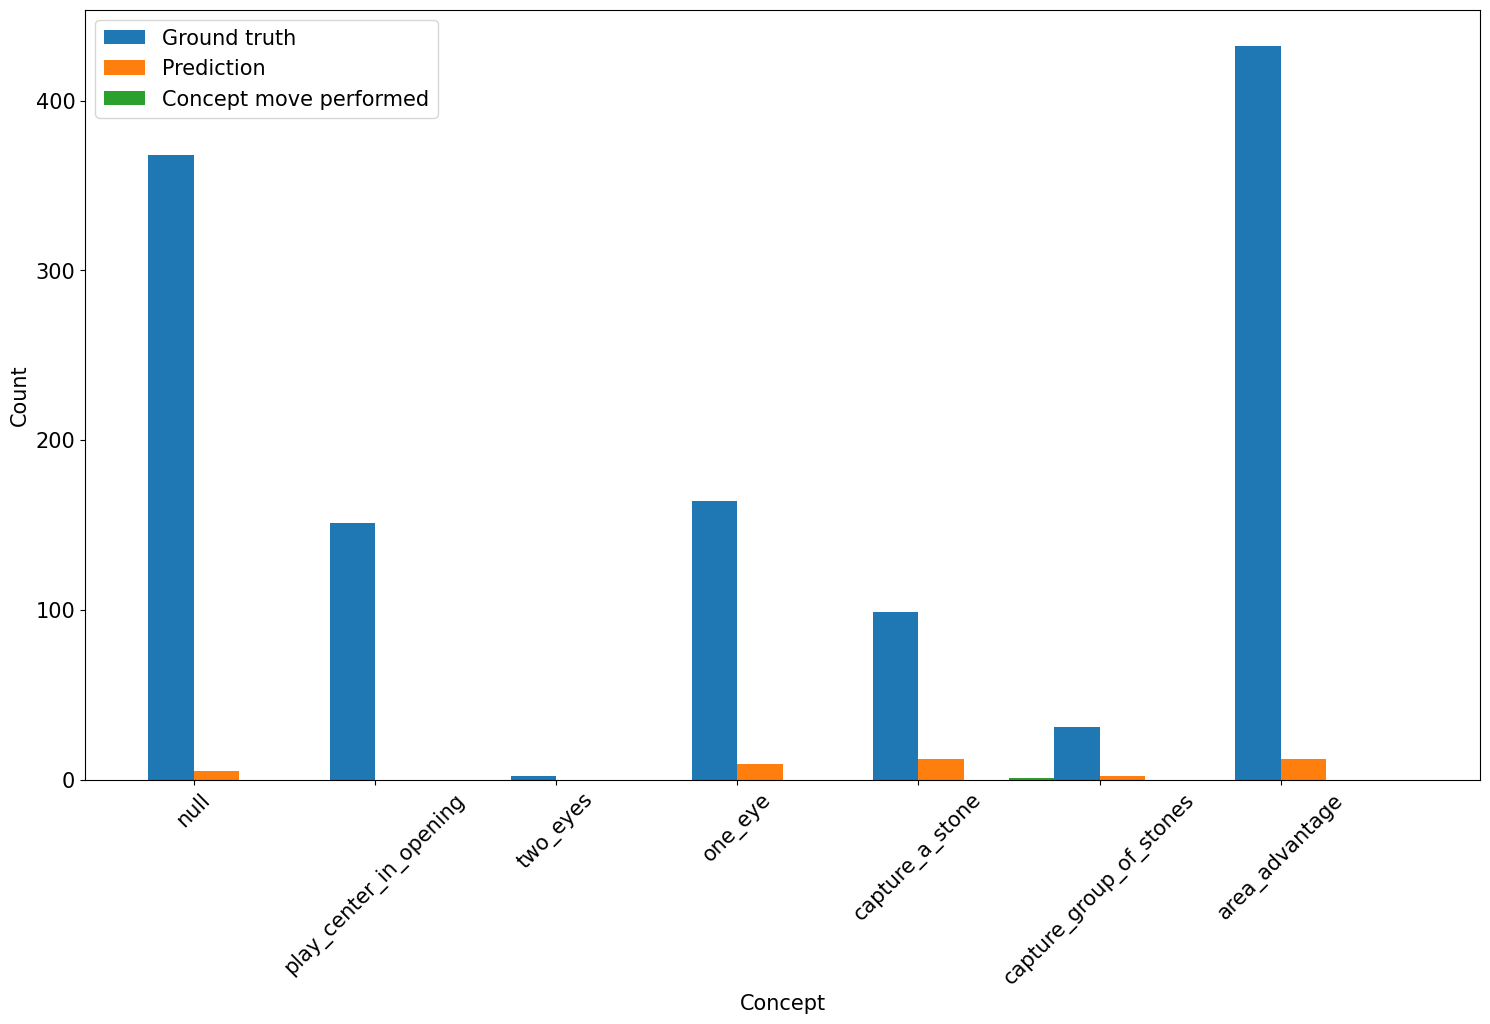

In [11]:
concepts_gt_dict = data_utils.concept_functions_to_dict()
concepts_pred_dict = data_utils.concept_functions_to_dict()
distribution_pred_dict = data_utils.concept_functions_to_dict()

# Plot the accuracy of each individual concept in the bottleneck layer
for i, concept in enumerate(concepts):
    # Find the index with the highest value in the prediction
    pred = concept_pred[i]

    dist_pred = distribution_pred[i].argmax()

    dist_gt = distributions[i].argmax()
    
    # Find all the indices where the concept is 1
    concept_indices = np.where(concept == 1)[0]
    for idx in concept_indices:
        concept_name = data_utils.concept_idx_to_name(idx)
        concepts_gt_dict[concept_name] += 1
    
    # Find the index of the x largest values in the prediction
    x = 1
    pred_indices = np.argpartition(pred, -x)[-x:]
    for idx in pred_indices:
        if idx in concept_indices:
            concept_name = data_utils.concept_idx_to_name(idx)
            concepts_pred_dict[concept_name] += 1
            concept_indices = concept_indices[concept_indices != idx]

            if dist_pred == dist_gt:
                distribution_pred_dict[data_utils.concept_idx_to_name(idx)] += 1
        
        if len(concept_indices) == 0:
            break

# Plot the concepts_gt_dict and concepts_pred_dict
fig, ax = plt.subplots()
index = np.arange(len(concepts_gt_dict.keys()))
bar_width = 0.25

# Set the window size
fig.set_size_inches(18, 10)

rects1 = ax.bar(index, concepts_gt_dict.values(), bar_width, label='Ground truth')
rects2 = ax.bar(index + bar_width, concepts_pred_dict.values(), bar_width, label='Prediction')

# Add the distribution_gt_dict and distribution_pred_dict
rects3 = ax.bar(index + 3 * bar_width, distribution_pred_dict.values(), bar_width, label='Concept move performed')

ax.set_xlabel('Concept', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
#ax.set_title('Concept bottleneck model predictions', fontsize=20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(concepts_gt_dict.keys())

# Add this line to increase the font size of the x-ticks to 15
ax.tick_params(axis='x', labelsize=15, rotation=45)

# Add this line to increase the font size of the y-ticks to 15
ax.tick_params(axis='y', labelsize=15)
ax.legend(fontsize=15)

plt.show()